# Internal Resistance Calculation for Small Vertical Axis Wind Turbine
**Author:** Ian Eykamp, **Date:** 6/16/2023

## Purpose
All generators have some amount of internal resistance, which allows there to be a variable voltage drop across the terminals, even if the generator always outputs the same emf. By connecting various resistors across the terminals (using no resistance as a baseline), I can figure out what the internal resistance is.

### Import libraries
`plecs_helper.py` is a file I created which defines some helper functions for nice plots and getting data off the oscilloscope and out of PLECS.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry, Quantity
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: TkAgg


### Import Data
I connected the oscilloscope leads between two terminals of the generator (the third terminal was left dangling). I set the oscilloscope up with 2V/division (y axis) and 5s/division (time axis). That way, I got a trace which lasted more than 30 seconds, enough for it to slow down considerably. I used the data density setting of 12k data points, and this was easily able to capture all the peaks. I spun the turbine by hand by giving it a moderate shove. It started spinning with a frequency around 6Hz, and as it slowed down, I was able to capture its frequency and amplitude on the oscilloscope.

I captured one dataset with no load, and three further datasets at 100Ohm, 6.8Ohm, and (6.8 || (6.8 + 6.8)) Ohm loads between the terminals I was measuring.

In [35]:
# Import data
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/unloaded.csv", ch1 = "unloaded")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/100Ohm.csv", ch1 = "100Ohm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/6_8Ohm.csv", ch1 = "6.8Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/4_5Ohm.csv", ch1 = "4.5Ohm")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
# print(df.head(20))

### Plot Data
I calculated the frequency by looking at the spacing of the peaks. After smoothing out the frequency and the peak values, I found the location where each trace crossed 4Hz and took the amplitude at that location. Since the amplitude depends on frequency, this is to normalize across datasets, since the turbine is not necsessarily spinning at the same frequency at the same timestamp.

C:\Users\ieykamp\AppData\Local\Temp\ipykernel_13348\1153253338.py:36: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_13348\1153253338.py:36: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_13348\1153253338.py:36: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]


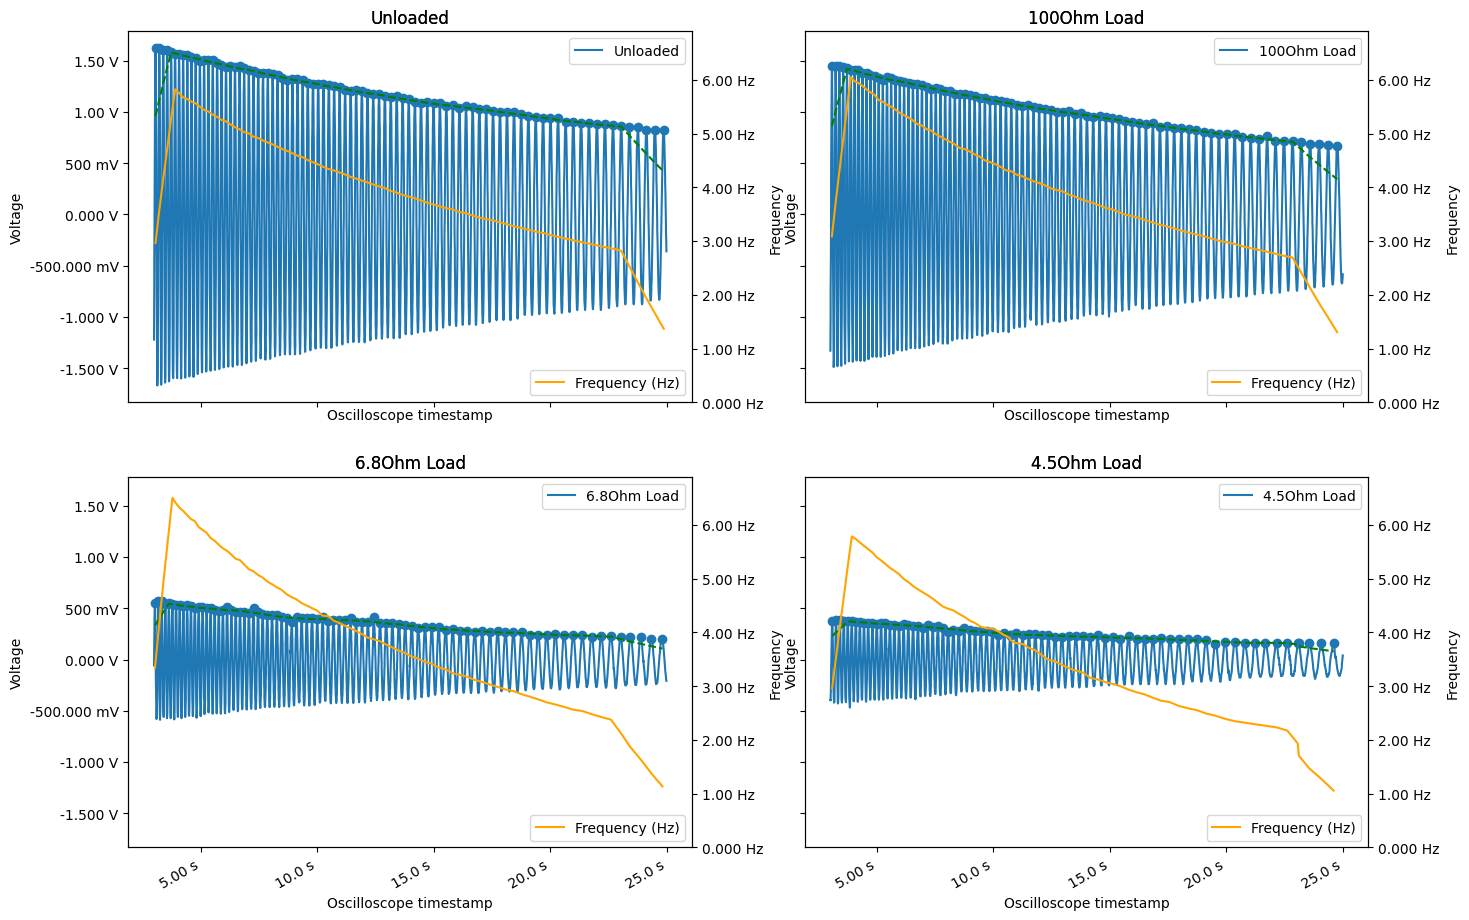

In [36]:
def moving_average(x, w):
    w = int(w / 2) * 2
    convolution = np.convolve(x, np.ones(w), 'full') / w
    return convolution[int(w/2):-int(w/2)+1]

def find_y_crossing_monotonic_decrease(y_vals, y_target):
    left_side_idx = list(np.arange(len(y_vals))[y_vals > y_target])
    return left_side_idx[-1]

def interpolate_outliers(y_vals, outlier_bool):
    outlier_idx = np.nonzero(outlier_bool)[0]
    if len(outlier_idx) == 0:
        return y_vals
    assert(all(np.diff(outlier_idx) > 1))
    assert(all(outlier_idx > 0) and all(outlier_idx < len(y_vals - 1))) # not the first or last element
    for idx in outlier_idx:
        y_vals[idx] = (y_vals[idx - 1] + y_vals[idx + 1]) / 2
    return y_vals

df_zoom = df[(df["t"] > 3) & (df["t"] < 25)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (16, 12))
fig.autofmt_xdate()

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["unloaded", "100Ohm", "6.8Ohm", "4.5Ohm"]
label_list = ["Unloaded", "100Ohm Load", "6.8Ohm Load", "4.5Ohm Load"]


amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)

    ax.plot(df_zoom["t"], df_zoom[channel], label = label)

    # find peaks for frequency and envelope amplitude analysis
    peak_idx = find_peaks(df_zoom[channel], distance = 25, width = 25)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]
    smooth_peaks = moving_average(df_peak_trace[channel], 10)

    # find frequency using time difference between peaks
    frequency = np.hstack((0, 1 / (np.diff(df_peak_trace["t"]))))
    smooth_frequency = moving_average(interpolate_outliers(frequency, frequency > 20), 10)
    
    # find the envelope amplitude at a certain frequency for normalized comparison between datasets
    target_freq = 4 # Hz
    target_freq_idx = find_y_crossing_monotonic_decrease(y_vals = smooth_frequency, y_target = target_freq)
    amplitude_at_target_freq = smooth_peaks[target_freq_idx]
    amplitudes.append(amplitude_at_target_freq)

    # plot peaks
    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    ax.plot(df_peak_trace["t"], smooth_peaks, linestyle = "dashed", color = "green")
    ax.legend(loc = "upper right")
    
    # plot frequency
    rax = ax.twinx()
    helper.axes_labels("Oscilloscope timestamp", "s", "Frequency", "Hz", title = label, ax = rax)
    rax.plot(df_peak_trace["t"], smooth_frequency, color = "orange", label = "Frequency (Hz)")
    rax.set_ylim(0, 6.9)
    rax.legend(loc = "lower right")

The abrupt drop off in frequency near the end is a figment of the smoothing algorithm and can be ignored.

The amplitudes at 4Hz are as follows. I calcualted the internal resistance $R_1$ using the following equation, based on the load resistor I was using: $R1 = R2 \cdot (\frac{V_{in}}{V_{out}} - 1)$, where $V_{in}$ is the unloaded amplitude and $V_{out}$ is the amplitude given a load resistor of $R_2$. The internal resistance of the generator is approximately $14.5 \Omega \pm 1 \Omega$.

In [37]:
def calculate_R1(Vin, Vout, R2):
    R1 = R2 * (Vin / Vout - 1)
    return R1

print("Amplitude with no load at 4Hz =", np.round(amplitudes[0], 3) * units.volt)
print("Amplitude with 100Ω load at 4Hz =", np.round(amplitudes[1], 3) * units.volt)
print("Amplitude with 6.8Ω load at 4Hz =", np.round(amplitudes[2], 3) * units.volt)
print("Amplitude with 4.5Ω load at 4Hz =", np.round(amplitudes[3], 3) * units.volt)
print("")

print("Three different calculations for internal resistance:")
R1_100Ohm_test = calculate_R1(amplitudes[0] * units.volt, amplitudes[1] * units.volt, 100 * units.ohm)
print(f"R1 = {R1_100Ohm_test}")
R1_6_8Ohm_test = calculate_R1(amplitudes[0] * units.volt, amplitudes[2] * units.volt, 6.8 * units.ohm)
print(f"R1 = {R1_6_8Ohm_test}")
R1_4_5Ohm_test = calculate_R1(amplitudes[0] * units.volt, amplitudes[3] * units.volt, 1/(1/6.8 + 1/(2 * 6.8)) * units.ohm)
print(f"R1 = {R1_4_5Ohm_test}")

R1 = np.mean(Quantity.from_list([R1_100Ohm_test, R1_6_8Ohm_test, R1_4_5Ohm_test]))
print(f"Average R1 = {np.round(R1, 2)}")

Amplitude with no load at 4Hz = 1.17 V
Amplitude with 100Ω load at 4Hz = 1.02 V
Amplitude with 6.8Ω load at 4Hz = 0.38 V
Amplitude with 4.5Ω load at 4Hz = 0.26 V

Three different calculations for internal resistance:
R1 = 13.97 Ω
R1 = 14.17 Ω
R1 = 15.93 Ω
Average R1 = 14.69 ohm


## Calculating maximum current

The buck converter will draw a certain average current from the rectifier; in doing so, it produces a known output voltage (the battery voltage, which may be between 12V and 14.6V) and a known output current. The buck converter acts like an ideal transformer in that it preserves the product of voltage and amperage from the input to the output, $P_{in} = V_{in} \cdot I_{in} = V_{out} \cdot I_{out} = P_{out}$. The input voltage is the voltage between the terminals of the rectifier. Using this, we can calculate $I_{in} = V_{out} \cdot I_{out} / V_{in}$. Once we have $I_{in}$, we can calculate the voltage drop across the internal resistance of the generator by $V = IR$. I will call this $\Delta V_{internal}$. The voltage now available for the buck converter to use is $V_{in} = V_{gen} - \Delta V_{internal}$. So, depending on how much output current we want to draw into the battery, it will affect the voltage available at the buck converter input.

We need to charge a 12V battery (really, when it’s done charging, it will be at 14.6V) using our buck converter. Because of the chip we are using, our buck converter can have no more than a 50% duty cycle, which means our input voltage must be at least $2 \cdot 14.6V = 29.2V$ at a bare minimum. Round up to $V_{in} = 30V$ at a minimum.

To spin the generator and get power out of it, I will place it in front of the 4th floor wind tunnel in the Rocketry lab. Without getting to a point where I felt it was dangerous, I can get it to 30V with a 100Ω load resistance. I am confident I can spin it faster if we need a higher voltage; in fact, I made my design with 50V or higher in mind.

We know our voltage divider has to give us at least 30V from the 50V available. That means there can be no more than a 20V drop across the 14.5Ω internal resistance, which corresponds with a 1.3A current through the rectifier.

We have $I_{in} = 1.3A$, $V_{in} = 30V$, $V_{out} = 14.6V$, and $V_{in} \cdot I_{in} = V_{out} \cdot I_{out}$. Thus, the maximum current we can safely draw for a 50V generator voltage is 2.8A. Likely, the available current to the battery would be much smaller because the power converter is not 100% efficient (in fact 70% or 80% efficiency is a fairly good design) and because there are many auxiliary IC’s and the microcontroller that will eat up a lot of the excess current.

Well, I guess I’ll just keep our current down between 0 and 0.5A to be safe. (Just kidding, I already designed the thing with a maximum of 0.5A in mind, and I don't want to redo all the analysis after realizing that 1A or more would be fine).

In [38]:
Vout = 14.6 * units.volt # battery voltage
Rinternal = 14.5 * units.ohm
Vgen = 50 * units.volt
Vin = 30 * units.volt
Vinternal = Vgen - Vin
Iin = Vinternal / Rinternal
Iout = Iin * Vin / Vout
print(f"Assuming Vgen = 50V, we have Iout = {Iout.to_compact(units.amp)}")

Assuming Vgen = 50V, we have Iout = 2.83 A


At 0.5A of output current, it would take only 35V at the generator, or actually probably closer to 40V because of the inefficiencies.

In [39]:
Vout = 14.6 * units.volt # battery voltage
Rinternal = 14.5 * units.ohm
Vin = 30 * units.volt
Iout = 0.5 * units.amp + 0.5 * units.amp
Vgen = Vin + Iout * Vout / Vin * Rinternal
print(f"Assuming Iout = 0.5A, with another 0.5A for auxiliary components, we need Vgen = {Vgen.to_compact(units.volt)}")

Assuming Iout = 0.5A, with another 0.5A for auxiliary components, we need Vgen = 37.06 V


## Calculating Input Capacitance

This averaged transformer analysis has all been made possible by assuming the input voltage does not change in response to the switching 

We have been calculating using the average input and output currents. For the buck converter to work properly, it needs to satisfy the input voltage even at the moment of peak current draw. In boundary conduction mode (BCM) where we are nominally operating, the peak current is two times the average current. For higher currents, we will go into continuous conduction mode (CCM), where the peak current is slightly less than twice the average current; for lower currents, we will go into discontinuous conduction mode (DCM) and require more than twice the average current at the peak.

Fortunately, if we have a big enough input capacitor, then we can smooth out the current waveform and almost exclusively care about the average current. By $I = C \frac{dV}{dt}$, there is always some voltage drop at the Vin node when the extra current is being sourced by the capacitor, but by choosing a large enough capacitance value, we can keep the voltage change to within +/- 1V of the average $\Delta V_{internal}$.

The source current follows a triangular waveform where it rises linearly from its starting current $I_{min}$ to $I_{peak}$ and then falls to zero. If we integrate this current over time, we get the total charge that is transferred during the upwards ramp as $\int_{t = 0s}^{D \cdot T_s} I_g dt = \frac{1}{2}T_s \cdot D \cdot (I_{peak} - I_{min}) + T_s \cdot D \cdot I_{min}$. If we are okay with rounding up by a factor of two, we can pretend the current is always $I_{peak}$, so that the charge becomes $Q = T_s \cdot D \cdot I_{peak}$. During this time, a current of $I_{avg} = \frac{I_{peak}}{2}$ is always being sourced by the generator, which over the switching cycle is $Q = T_s \cdot D \cdot \frac{I_{peak}}{2}$. So our capacitor only needs to source the other $T_s \cdot D \cdot \frac{I_{peak}}{2}$ of the charge, all while depleting only 1V of its voltage.

In reality, the charge required is about half of that value for CCM and BCM and has a limit approaching that value as we go deep into DCM.

We have $C = \frac{Q}{V}$, so we have $C_{input} = \frac{T_s \cdot D \cdot \frac{I_{peak}}{2}}{1V}$

In [45]:
Fs = 50 * units.kilohertz
Ts = 1 / Fs
D = 0.36
Ipeak = 1 * units.amp
Vripple = 1 * units.volt

Cinput = Ts * D * Ipeak / 2 / Vripple
print(f"Cinput = {Cinput.to_compact(units.farad)}")

Cinput = 3.60 µF


So yeah, 10uF should be about enough.

## Calculating Diff Amp Slew Rate Across Shunt Resistors

The slope of the current waveform over time is linear and determined by the inductance value we chose for the inductor, $V_L = L \cdot \frac{dI}{dt}$, where $V_L = V_g - V_{bat}$, so $\frac{dI}{dt} = \frac{(V_g - V_{bat})}{L}$. We chose the up-going slope because it is necessarily steeper than the down-going slope because we are limited to a <50% duty cycle. This tells us the rate of current rise across the first shunt resistor. Due to the low-pass filtering of the capacitor, the rate of rise of the second shunt resistor will be smaller. For a given rise in current $\Delta I$, the voltage across the shunt resistor will rise by $\Delta V = \Delta I \cdot R_{shunt}$. Therefore, the slew rate of the voltage rise across the shunt resistor will be $\frac{dV_{shunt}}{dt} = \frac{dI}{dt} \cdot R_{shunt} = \frac{(V_g - V_{bat})}{L} \cdot R_{shunt}$.

In [48]:
Rshunt = 50 * units.milliohm
Vg = 40 * units.volt
Vbat = 12 * units.volt
L = 345 * units.microhenry
dIdt = (Vg - Vbat) / L * Rshunt
print(f"Slew rate = {dIdt.to(units.volt / units.microsecond):.2e}")

Slew rate = 4.06e-03 volt / microsecond


10mOhm * 2A
P = I^2*R

In [50]:
Ipeak = 2 * units.amp
Rshunt = 10 * units.milliohm
shunt_resistor_power_rating = Ipeak ** 2 * Rshunt
print(f"Shunt Resistor Power = {shunt_resistor_power_rating.to_compact(units.watt):.2f}")

Shunt Resistor Power = 40.00 milliwatt


## LED resistor calculations
3 voltage levels: 15V, 5V, and 3.3V
2V forward voltage across LEDs
30mA maximum DC current, aiming for 10mA

In [52]:
V1 = 50 * units.volt
V2 = 5 * units.volt
V3 = 3.3 * units.volt
VF = 2 * units.volt
Idesired = 10 * units.milliamp

R1 = (V1 - VF) / Idesired
R2 = (V2 - VF) / Idesired
R3 = (V3 - VF) / Idesired
print(f"R1 = {R1.to_compact(units.ohm):.2f}")
print(f"R2 = {R2.to_compact(units.ohm):.2f}")
print(f"R3 = {R3.to_compact(units.ohm):.2f}")

R1 = 1.30 kiloohm
R2 = 300.00 ohm
R3 = 130.00 ohm
